# 第 6 章 网络结构数据的社区发现

## 导入库

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

from modules.tools import graph_info, map_color, cluster_layout

# 设置图形的显示风格和中文显示
sns.set_theme(font='SimHei')

## 导入数据

In [2]:
# 读取数据
karate = nx.read_graphml('../../Data/karate.graphml')
graph_info(karate)

Zachary's karate club network with 34 nodes and 78 edges.
Graph type:      undirected weighted 
Node attributes: Faction name label color 
Edge attributes: weight 
Edge list:
[ 0] Mr Hi    -- Actor 2 	[ 1] Mr Hi    -- Actor 3 	[ 2] Mr Hi    -- Actor 4 
[ 3] Mr Hi    -- Actor 5 	[ 4] Mr Hi    -- Actor 6 	[ 5] Mr Hi    -- Actor 7 
[ 6] Mr Hi    -- Actor 8 	[ 7] Mr Hi    -- Actor 9 	[ 8] Mr Hi    -- Actor 11
[ 9] Mr Hi    -- Actor 12	[10] Mr Hi    -- Actor 13	[11] Mr Hi    -- Actor 14
[12] Mr Hi    -- Actor 18	[13] Mr Hi    -- Actor 20	[14] Mr Hi    -- Actor 22
[15] Mr Hi    -- Actor 32	[16] Actor 2  -- Actor 3 	[17] Actor 2  -- Actor 4 
...


## edge betweenness算法

In [3]:
# Girvan-Newman算法， 默认使用networkx.edge_betweenness_centrality作为most_valuable_edge的度量
com_GN = nx.algorithms.community.girvan_newman(karate)
com_GN = list(com_GN) # 转换为list，方便查看结果
# 查看结果：
print(f"共进行了{len(com_GN)}次划分，前5次划分的结果：")
for i in range(5):
    print(f"第{i+1}次 划分出的社区数：{len(com_GN[i])}")

共进行了33次划分，前5次划分的结果：
第1次 划分出的社区数：2
第2次 划分出的社区数：3
第3次 划分出的社区数：4
第4次 划分出的社区数：5
第5次 划分出的社区数：6


In [4]:
# 使用Modularity最大时的划分作为最终结果
com_GN_modularity = {}
for i, com in enumerate(com_GN):
    # 计算模块度
    com_GN_modularity[i] = nx.algorithms.community.quality.modularity(karate, com)
# 按照模块度降序排列
com_GN_modularity = sorted(com_GN_modularity.items(), key=lambda x: x[1], reverse=True)
# 最终结果
com_GN_best = com_GN[com_GN_modularity[0][0]]
print("最终结果：")
print(f"最终划分的社区数：{len(com_GN_best)}")
for i, com in enumerate(com_GN_best):
    print(f"社区{i+1}: {com}")

最终结果：
最终划分的社区数：5
社区1: {'n0', 'n17', 'n21', 'n13', 'n12', 'n19', 'n3', 'n11', 'n1', 'n7'}
社区2: {'n27', 'n25', 'n28', 'n31', 'n2', 'n24'}
社区3: {'n16', 'n4', 'n5', 'n6', 'n10'}
社区4: {'n33', 'n30', 'n23', 'n29', 'n8', 'n18', 'n26', 'n22', 'n20', 'n15', 'n14', 'n32'}
社区5: {'n9'}


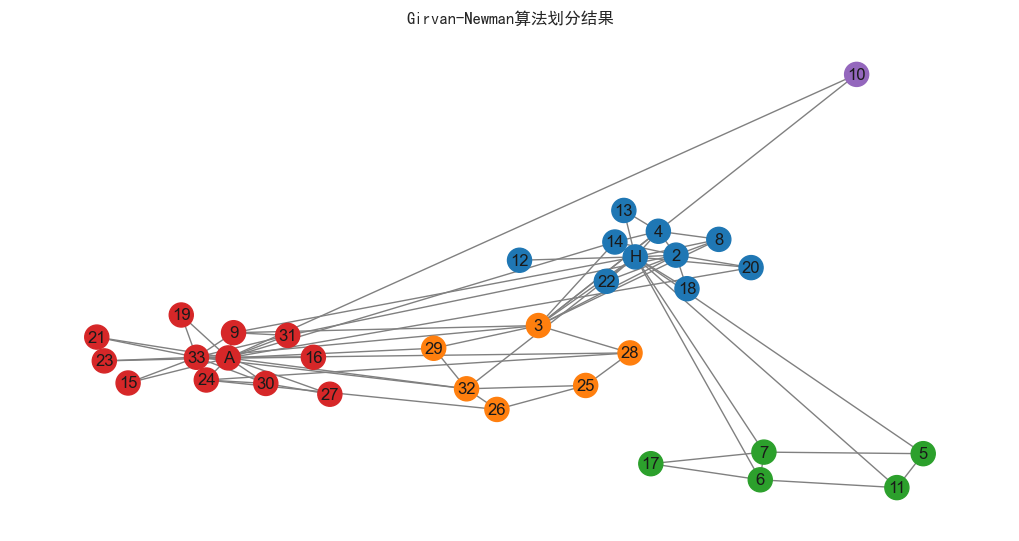

In [14]:
# 为每个节点添加属性，表示其所属的社区
for i, c in enumerate(com_GN_best):
    for n in c:
        karate.nodes[n]['GN_best'] = i

# 设置画布
plt.figure(figsize=(10, 5))
# 设置节点的位置
pos = cluster_layout(karate, com_GN_best, seed=42)
# 绘制图形
nx.draw(
    karate, pos, 
    node_color=map_color(karate, 'GN_best'), 
    labels=nx.get_node_attributes(karate, 'label'),
    edge_color='gray'
)
# 添加标题
plt.title('Girvan-Newman算法划分结果')
plt.show()

In [6]:
# 计算社区数量
len(com_GN_best)

5

In [7]:
# 计算每个社区大小
[len(c) for c in com_GN_best]

[10, 6, 5, 12, 1]

In [8]:
# 展示每个节点所属的社区。为节省空间，仅展示五个节点
for n, attr in list(karate.nodes(data=True))[:5]:
    print(f"节点 {attr['name']}\t所属的社区：{attr['GN_best']}")

节点 Mr Hi	所属的社区：0
节点 Actor 2	所属的社区：0
节点 Actor 3	所属的社区：1
节点 Actor 4	所属的社区：0
节点 Actor 5	所属的社区：2


In [9]:
# 展示每个社区的节点。为节省空间，仅展示第一个社区
for n, attr in list(karate.nodes(data=True)):
    if attr['GN_best'] == 0:
        print(f"节点 {attr['name']}\t所属的社区：{attr['GN_best']}")

节点 Mr Hi	所属的社区：0
节点 Actor 2	所属的社区：0
节点 Actor 4	所属的社区：0
节点 Actor 8	所属的社区：0
节点 Actor 12	所属的社区：0
节点 Actor 13	所属的社区：0
节点 Actor 14	所属的社区：0
节点 Actor 18	所属的社区：0
节点 Actor 20	所属的社区：0
节点 Actor 22	所属的社区：0


In [10]:
# 计算社区划分下的模块度
nx.algorithms.community.quality.modularity(karate, com_GN_best)

0.3849721706864564

In [11]:
# 展示每条边是否是跨社区的边。如果这条边连接两个不同社区，则输出“True”，否则输出“False”
# 为节省空间，仅展示两条边
for n1, n2 in list(karate.edges())[:2]:
    if karate.nodes[n1]['GN_best'] != karate.nodes[n2]['GN_best']:
        print(f"边 {karate.nodes[n1]['name']} - {karate.nodes[n2]['name']} 是跨社区的边")
    else:
        print(f"边 {karate.nodes[n1]['name']} - {karate.nodes[n2]['name']} 不是跨社区的边")

边 Mr Hi - Actor 2 不是跨社区的边
边 Mr Hi - Actor 3 是跨社区的边


In [12]:
# 查看社区数量为2时的划分结果
for com in com_GN:
    if len(com) == 2:
        com_GN_2 = com
        break
# 查看结果：
for i, com in enumerate(com_GN_2):
    print(f"社区{i+1}: {com}")

社区1: {'n0', 'n16', 'n17', 'n21', 'n5', 'n4', 'n13', 'n12', 'n19', 'n3', 'n6', 'n10', 'n1', 'n11', 'n7'}
社区2: {'n27', 'n23', 'n22', 'n20', 'n14', 'n30', 'n25', 'n8', 'n18', 'n32', 'n24', 'n2', 'n9', 'n33', 'n28', 'n29', 'n26', 'n31', 'n15'}


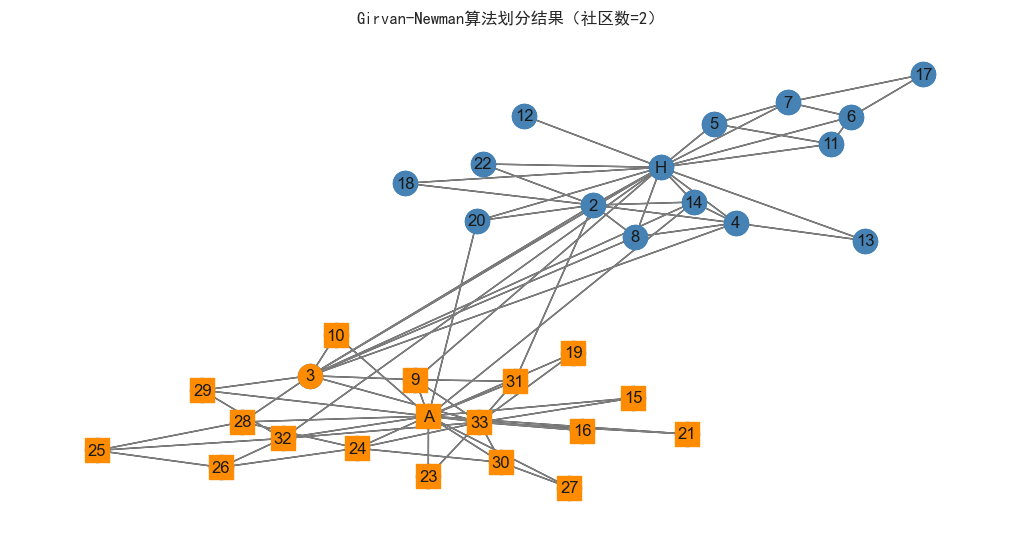

In [24]:
# 为每个节点添加属性，表示其所属的社区
for i, c in enumerate(com_GN_2):
    for n in c:
        karate.nodes[n]['GN_2'] = i

# 设置画布
plt.figure(figsize=(10, 5))
# 设置节点的位置
pos = cluster_layout(karate, com_GN_2, seed=42)

# 绘制图形
nx.draw(karate, pos, labels=nx.get_node_attributes(karate, 'label'))
for n, attr in list(karate.nodes(data=True)):
    # 设置节点的颜色-算法识别的社区
    if attr['GN_2'] == 0:
        node_color = 'steelblue'
    else:
        node_color = 'darkorange'
    # 设置节点的形状-真实的社区
    if attr['Faction'] == 1:
        node_shape = 'o'
    else:
        node_shape = 's'
    nx.draw_networkx_nodes(
        karate, pos, nodelist=[n], node_color=node_color, node_shape=node_shape
    )
nx.draw_networkx_edges(karate, pos, edge_color='gray')

# 添加标题
plt.title('Girvan-Newman算法划分结果（社区数=2）')
plt.show()


可以看到，只有一个节点`9`被错误的划分到了另一个社区中，其余的节点都被正确的划分到了对应的社区中。

## fast greedy算法